In [1]:
%matplotlib inline

import glob
import os
import pandas as pd
import numpy as np
import random
from datetime import datetime

from sklearn.metrics.pairwise import cosine_similarity
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from pandas.plotting import autocorrelation_plot

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import pyplot
matplotlib.style.use('ggplot')

import seaborn as sns
# sns.set(context='paper', style='whitegrid', color_codes=True)   
sns.set_palette(sns.color_palette(["#017b92", "#f97306", "#ff0000"]))  # ["green", "orange", "red"] 

import warnings
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (20,4)

# Read data

In [2]:
mods2_data = True

if mods2_data:
    # fn = 'data/tools_kafka-services_mods_models_buffer-all.txt'
    fn = 'data/buffer-20210325-20210406.tsv'
    # fn = 'data/buffer-20210415-20210526.tsv'
    df = pd.read_csv(fn, sep='\t')
    df = df.set_index('ts')
    df.index = pd.to_datetime(df.index)
    # df = df[400:]
else:
    import mods_utils
    data_select_query = \
        'conn|in_count_uid|out_count_uid;' +\
        'dns|out_count_uid;' + \
        'http|in|out;' +\
        'ssl|in' + \
        '#window_start,window_end'
        #'sip|in_count_uid~in;' +\
    mods_utils.create_files_from_tsv(
        output_dir='data/', 
        ws_choice='w10m-s10m', 
        app_data_features='data/tsv/', 
        time_range_begin ='20190501', #'20190101', '20190901', '20200101', '20200710', '20200817', 'pokojne normalne data na train'
        time_range_end   ='20190601', #'20190601', '20191001', '20200201', '20200801', '20200901'
        time_range_excluded=[]
    )
    mods_utils.merge_files_on_cols(
        output_filename='data/mods1-data.tsv', 
        data_pool='data/w10m-s10m',
        data_select_query=data_select_query
    )
    fn = 'data/mods1-data.tsv'
    df = pd.read_csv(fn, sep='\t')

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1726 entries, 2021-03-25 11:00:00 to 2021-04-06 11:30:00
Columns: 101 entries, conn_count_uid_in to ssl_nunique_uid_out
dtypes: float64(101)
memory usage: 1.3 MB


In [3]:
df.describe()

,conn_count_uid_in,conn_count_uid_internal,conn_count_uid_out,conn_mean_duration_in,conn_mean_duration_internal,conn_mean_duration_out,conn_nunique_uid_in,conn_nunique_uid_internal,conn_nunique_uid_out,conn_sum_orig_bytes_in,...,ssh_count_uid_out,ssh_nunique_uid_in,ssh_nunique_uid_internal,ssh_nunique_uid_out,ssl_count_uid_in,ssl_count_uid_internal,ssl_count_uid_out,ssl_nunique_uid_in,ssl_nunique_uid_internal,ssl_nunique_uid_out
count,1726.000000,1726.000000,1726.000000,1726.000000,1726.000000,1726.000000,1726.000000,1726.000000,1726.000000,1.726000e+03,...,59.000000,1726.000000,74.000000,59.000000,1726.000000,425.000000,1726.000000,1726.000000,425.000000,1726.000000
mean,16666.064311,2863.413094,1912.282735,17.864186,1.003363,6.778962,16666.064311,2863.413094,1912.282735,7.058697e+09,...,1.644068,1335.501738,2.283784,1.644068,298.880070,103.164706,115.974508,298.880070,103.164706,115.974508
std,11612.159690,712.562876,482.341022,47.474794,9.988050,88.578072,11612.159690,712.562876,482.341022,4.309113e+10,...,0.713484,1303.982969,3.233050,0.713484,66.697814,91.752287,119.890484,66.697814,91.752287,119.890484
min,7326.000000,1592.000000,846.000000,0.597071,0.109535,0.576648,7326.000000,1592.000000,846.000000,1.547070e+06,...,1.000000,133.000000,1.000000,1.000000,189.000000,1.000000,83.000000,189.000000,1.000000,83.000000
25%,10431.250000,2496.000000,1634.000000,3.795748,0.296964,1.689332,10431.250000,2496.000000,1634.000000,3.250758e+06,...,1.000000,628.250000,1.000000,1.000000,247.000000,2.000000,100.000000,247.000000,2.000000,100.000000
50%,11856.000000,2785.500000,1833.500000,7.199450,0.335384,2.198733,11856.000000,2785.500000,1833.500000,1.366032e+09,...,2.000000,843.000000,1.000000,2.000000,295.000000,104.000000,104.000000,295.000000,104.000000,104.000000
75%,17538.250000,3034.750000,2122.750000,16.426182,0.386335,3.058558,17538.250000,3034.750000,2122.750000,6.294843e+09,...,2.000000,1504.500000,2.000000,2.000000,331.000000,198.000000,111.000000,331.000000,198.000000,111.000000
max,69692.000000,7255.000000,6659.000000,988.495659,329.590611,3043.756391,69692.000000,7255.000000,6659.000000,1.407903e+12,...,5.000000,12225.000000,23.000000,5.000000,930.000000,308.000000,4502.000000,930.000000,308.000000,4502.000000


In [4]:
# sns.displot(df['ssl_count_uid_in'], kde=True)
# df.plot(y='ssl_count_uid_in', use_index=True)

# Data cleaning

### Remove internal protocols

In [5]:
internal_cols = [col for col in df.columns if 'internal' in col ]

# drop them
print('Remove internal columns:', len(internal_cols))
df.drop(columns=internal_cols, inplace=True)
internal_cols

Remove internal columns: 27


['conn_count_uid_internal',
 'conn_mean_duration_internal',
 'conn_nunique_uid_internal',
 'conn_sum_orig_bytes_internal',
 'conn_sum_resp_bytes_internal',
 'dns_AA_F_internal_count',
 'dns_AA_T_internal_count',
 'dns_RA_F_internal_count',
 'dns_RA_T_internal_count',
 'dns_RD_F_internal_count',
 'dns_RD_T_internal_count',
 'dns_TC_F_internal_count',
 'dns_TC_T_internal_count',
 'dns_count_proto_internal',
 'dns_count_query_internal',
 'dns_count_uid_internal',
 'dns_nunique_proto_internal',
 'dns_nunique_query_internal',
 'dns_nunique_uid_internal',
 'dns_rejected_F_internal_count',
 'dns_rejected_T_internal_count',
 'http_count_uid_internal',
 'http_nunique_uid_internal',
 'ssh_count_uid_internal',
 'ssh_nunique_uid_internal',
 'ssl_count_uid_internal',
 'ssl_nunique_uid_internal']

### DNS temporary removing

In [6]:
# conn_count_uid = conn_nunique_uid
# dns_count_proto = dns_count_query = dns_count_uid = dns_TC_F
# sip_count = sip_nunique
# sip_nunique_uid = sip_count_id.orig_h = sip_count_id.orig_p = sip_count_id.resp_h = sip_count_id.resp_h

test_dns_removing = True

if test_dns_removing:
    tmp_cols = []
    for col in df.columns:
        if  ('dns_A' in col)  or\
            ('dns_R' in col) or\
            ('dns_T' in col) or\
            ('dns_count_proto' in col) or\
            ('dns_count_query' in col) or\
            ('dns_rejected' in col):
            tmp_cols.append(col)

    # drop them
    print('Remove temporary columns:', len(tmp_cols))
    tmp_cols = list(tmp_cols)
    df.drop(columns=tmp_cols, inplace=True)
    tmp_cols

Remove temporary columns: 24


### Remove duplicated columns

In [7]:
duplicateColumnNames = set()
# df = df.reindex(sorted(df.columns), axis=1)

for i in range(df.shape[1]):
    print(df.columns[i])
    col = df.iloc[:, i]
    for j in range(i + 1, df.shape[1]):
        otherCol = df.iloc[:, j]
        if col.equals(otherCol):
            print('\t', df.columns[j])
            duplicateColumnNames.add(df.columns.values[j])

dup_cols = list(duplicateColumnNames)
print('Remove duplicated columns:', len(dup_cols))

# drop them
df.drop(columns=dup_cols, inplace=True)
dup_cols

conn_count_uid_in
	 conn_nunique_uid_in
conn_count_uid_out
	 conn_nunique_uid_out
conn_mean_duration_in
conn_mean_duration_out
conn_nunique_uid_in
conn_nunique_uid_out
conn_sum_orig_bytes_in
conn_sum_orig_bytes_out
conn_sum_resp_bytes_in
conn_sum_resp_bytes_out
dns_count_uid_in
dns_count_uid_out
dns_nunique_proto_in
dns_nunique_proto_out
dns_nunique_query_in
dns_nunique_query_out
dns_nunique_uid_in
dns_nunique_uid_out
http_count_uid_in
http_count_uid_out
http_nunique_uid_in
http_nunique_uid_out
sip_count_id.orig_h_in
	 sip_count_id.orig_p_in
	 sip_count_id.resp_h_in
	 sip_count_id.resp_p_in
	 sip_count_uid_in
	 sip_nunique_uid_in
sip_count_id.orig_h_out
	 sip_count_id.orig_p_out
	 sip_count_id.resp_h_out
	 sip_count_id.resp_p_out
	 sip_count_uid_out
	 sip_nunique_uid_out
sip_count_id.orig_p_in
	 sip_count_id.resp_h_in
	 sip_count_id.resp_p_in
	 sip_count_uid_in
	 sip_nunique_uid_in
sip_count_id.orig_p_out
	 sip_count_id.resp_h_out
	 sip_count_id.resp_p_out
	 sip_count_uid_out
	 sip_nun

['sip_nunique_id.resp_p_out',
 'ssl_nunique_uid_in',
 'sip_count_id.resp_p_in',
 'sip_count_uid_out',
 'ssh_nunique_uid_in',
 'sip_count_id.resp_h_in',
 'sip_count_id.orig_p_out',
 'sip_nunique_uid_in',
 'ssh_nunique_uid_out',
 'sip_count_uid_in',
 'sip_count_id.resp_h_out',
 'sip_count_id.resp_p_out',
 'conn_nunique_uid_out',
 'sip_count_id.orig_p_in',
 'conn_nunique_uid_in',
 'sip_nunique_uid_out',
 'ssl_nunique_uid_out']

### Remove columns if it contains less than 2% values

In [8]:
percent = 2
counts = df.nunique()

# col_indexes = [i for i,v in enumerate(counts) if (float(v)/df.shape[0]*100) < percent]
col_indexes = []
for i, v in enumerate(counts):
    p = float(v)/df.shape[0]*100
    if p < percent:
        print('\t', '{:.2f}'.format(p), df.columns[i])
        col_indexes.append(i)

col_names = df.columns[col_indexes]
print('Remove columns if it contains few unique values (less than 1%):', len(col_names))

# drop them
df.drop(columns=col_names, inplace=True)

	 0.12 dns_nunique_proto_in
	 0.12 dns_nunique_proto_out
	 0.29 sip_count_id.orig_h_out
	 0.93 sip_nunique_id.orig_h_in
	 0.23 sip_nunique_id.orig_h_out
	 1.56 sip_nunique_id.orig_p_in
	 0.12 sip_nunique_id.orig_p_out
	 0.06 sip_nunique_id.resp_h_out
	 0.23 ssh_count_uid_out
Remove columns if it contains few unique values (less than 1%): 9


### Remove columns with empty cells more than 5%

In [9]:
max_empty_percent = 5
print(df.isnull().sum(axis=0))

empty_cols = set()
for col in df.columns:
    percent = df[col].isnull().sum(axis=0) / df.shape[0]*100
    if percent > max_empty_percent:
        print(col, '\t', percent)
        empty_cols.add(col)
        
print('Remove columns with empty cells more than 5%:', len(empty_cols))
empty_cols = list(empty_cols)
df.drop(columns=empty_cols, inplace=True)
empty_cols

conn_count_uid_in             0
conn_count_uid_out            0
conn_mean_duration_in         0
conn_mean_duration_out        0
conn_sum_orig_bytes_in        0
conn_sum_orig_bytes_out       0
conn_sum_resp_bytes_in        0
conn_sum_resp_bytes_out       0
dns_count_uid_in              0
dns_count_uid_out             0
dns_nunique_query_in          0
dns_nunique_query_out         0
dns_nunique_uid_in            0
dns_nunique_uid_out           0
http_count_uid_in             0
http_count_uid_out          281
http_nunique_uid_in           0
http_nunique_uid_out        281
sip_count_id.orig_h_in      254
sip_nunique_id.resp_h_in    254
sip_nunique_id.resp_p_in    254
ssh_count_uid_in              0
ssl_count_uid_in              0
ssl_count_uid_out             0
dtype: int64
http_count_uid_out 	 16.280417149478563
http_nunique_uid_out 	 16.280417149478563
sip_count_id.orig_h_in 	 14.716106604866743
sip_nunique_id.resp_h_in 	 14.716106604866743
sip_nunique_id.resp_p_in 	 14.716106604866743
R

['http_nunique_uid_out',
 'sip_nunique_id.resp_h_in',
 'http_count_uid_out',
 'sip_count_id.orig_h_in',
 'sip_nunique_id.resp_p_in']

### Interpolate for missing NaN

In [10]:
df.interpolate(method='time', inplace=True)
# df.info()

### Remove similar columns: cosine similarity > 98%

In [11]:
max_similarity = 0.98   # in range <0, 1>

sim_cols = set()
for i in range(df.shape[1]):
    col = df.iloc[:, i]
    for j in range(i + 1, df.shape[1]):
        otherCol = df.iloc[:, j]
        cs = cosine_similarity(col.values.reshape(1, -1), otherCol.values.reshape(1, -1))
        if cs > max_similarity:
            print('\t', cs, df.columns[i], '\t', df.columns[j])
            sim_cols.add(df.columns.values[j])
            
print('Remove (cosine) similar columns to another one:', len(sim_cols))
sim_cols = list(sim_cols)
df.drop(columns=sim_cols, inplace=True)
sim_cols

	 [[0.99391175]] dns_count_uid_out 	 dns_nunique_uid_out
	 [[0.99248157]] http_count_uid_in 	 http_nunique_uid_in
Remove (cosine) similar columns to another one: 2


['http_nunique_uid_in', 'dns_nunique_uid_out']

# Test stationarity and randomness

### Augmented Dickey-Fuller (ADF) unit root test
Augmented Dickey-Fuller (ADF) unit root test is defined as follows:
- $H_0$: the data possesses a unit root (random walk) and it is non-stationary.
- $H_a$: the data is stationary.

Result intepretation:
- if ADF statistic test < 1% 5% 10% (Critical Values) then $H_0$ is rejected
- if P-Value < 0.05 then $H_0$ is rejected 

<b>A stationary series</b> is one where the values of the series is not a function of time t.j. 
the statistical properties of the series like mean, variance and autocorrelation are constant over time. 

<b>Autocorrelation</b> of the series is the correlation of the series with its previous values

In [12]:
cols_selected = []
for col in df.columns:
    missing = df[col].isnull().sum()
    if not missing:
        dftest = adfuller(df[col], autolag = 'AIC')
        if (dftest[1] < 0.05) and (dftest[2] > 3):
            cols_selected.append(col)
            print('\t', col, '\tp-value: ', dftest[1], '\tNum of lags: ', dftest[2])
            # print("\t1. ADF : ",dftest[0])
            # print("\t2. P-Value : ", dftest[1])
            # print("\t3. Num Of Lags : ", dftest[2])
            # print("\t4. Num of observations used for ADF regression and Critical Values calculation :", dftest[3])
            # print("\t5. Critical Values :")
            # for key, val in dftest[4].items():
            #    print("\t\t",key, ": ", val)   
        # plot_acf(df[col])
        # plt.show()
# '''
tmp = [#'conn_count_uid_in',         # a bit echo, 202008 data, MAPE=16, a bit echo
       #'conn_count_uid_out',        # OK, 202008 data, MAPE=12
       'conn_mean_duration_in',     # - 
       'conn_mean_duration_out',    # -
       'conn_sum_orig_bytes_in',    # - payload
       'conn_sum_orig_bytes_out',   # - payload
       'conn_sum_resp_bytes_in',    # - payload
       'conn_sum_resp_bytes_out',   # - payload 
       'dns_count_uid_in',          # -
       #'dns_count_uid_out',         # OK, 202008 data, MAPE=32, a bit echo pri vysokych spickach
       'dns_nunique_query_in',      # - 
       'dns_nunique_query_out',     # - 
       'dns_nunique_uid_in',        # moze byt MAPE=25
       #'http_count_uid_in',         # OK, MAPE=30 48 units, 202008 data, MAPE=19 60 units, nice
       'http_nunique_uid_out',      # OK, MAPE=60 48 units, 202008 data, MAPE=87 60 units, nice
       #'ssl_count_uid_in',          # OK, MAPE=15 48 units, 202008 data, MAPE=21 60 units, nice
       'ssl_count_uid_out',         # - 
      ]
# '''
# tmp = []
cols_selected = [x for x in cols_selected if x not in tmp]
print(len(cols_selected))
cols_selected

	 conn_count_uid_in 	p-value:  0.042660435771893886 	Num of lags:  13
	 conn_count_uid_out 	p-value:  5.245143664993132e-06 	Num of lags:  24
	 conn_mean_duration_in 	p-value:  2.5807684794395156e-16 	Num of lags:  10
	 conn_mean_duration_out 	p-value:  1.065759746405965e-18 	Num of lags:  12
	 conn_sum_orig_bytes_in 	p-value:  2.5441258215722124e-10 	Num of lags:  25
	 conn_sum_resp_bytes_in 	p-value:  9.598060839898392e-13 	Num of lags:  12
	 conn_sum_resp_bytes_out 	p-value:  2.3721175969150155e-24 	Num of lags:  4
	 dns_count_uid_in 	p-value:  9.695821460095122e-20 	Num of lags:  6
	 dns_count_uid_out 	p-value:  3.300263259939272e-07 	Num of lags:  24
	 dns_nunique_query_in 	p-value:  2.475762482971151e-06 	Num of lags:  25
	 dns_nunique_query_out 	p-value:  7.22811354928978e-05 	Num of lags:  25
	 dns_nunique_uid_in 	p-value:  8.182503310917187e-06 	Num of lags:  18
	 http_count_uid_in 	p-value:  1.538292967516793e-27 	Num of lags:  25
	 ssl_count_uid_in 	p-value:  7.7322768618037

['conn_count_uid_in',
 'conn_count_uid_out',
 'dns_count_uid_out',
 'http_count_uid_in',
 'ssl_count_uid_in']

In [13]:
# col1 = df['dns_count_uid_in']
# col2 = df['dns_nunique_query_in']
# col3 = df['dns_nunique_uid_in']
# cosine_similarity(col2.values.reshape(1, -1), col3.values.reshape(1, -1))

### Ljung-Box test for randomness
Formally, the Ljung-Box test can be defined as follows.
- $H_0$: the data is random.
- $H_a$: the data is not random.

Result intepretation:
- if P-Value < 0.05 then $H_0$ is rejected

In [14]:
test_ljungbox = False

if test_ljungbox:
    cols=cols_selected
    for col in cols:
        lbvalue, pvalue = acorr_ljungbox(df[col], lags=[3, 6, 24])
        if all(p < 0.05 for p in pvalue):
            print(col, '\t', pvalue)

### White noise
<b>White noise:</b> a sequence of completely random numbers with <b>mean zero</b> is a white noise.

In [15]:
test_white_noise = False

if test_white_noise:
    cols=cols_selected
    for col in cols:
        series = df[col]
        print(series.describe())
        plt.rcParams["figure.figsize"] = (15, 12)
        series.plot()
        series.hist()
        autocorrelation_plot(series)
        plt.show()

### Pearson correlations

<AxesSubplot:>

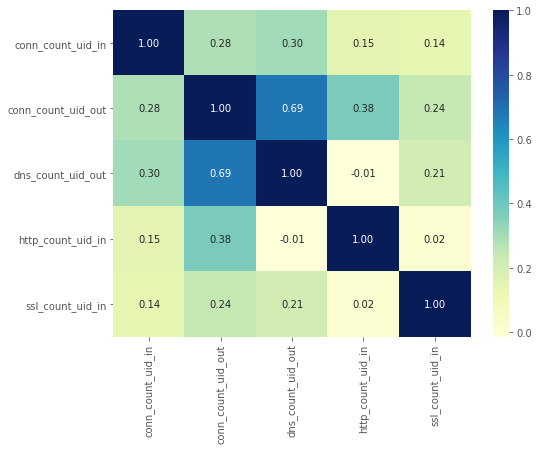

In [16]:
fig, ax = pyplot.subplots(figsize=(8, 6))
sns.heatmap(df[cols_selected].corr(), ax=ax, annot=True, fmt=".2f", cmap="YlGnBu")

# Data augmentation

### Clip peaks based on Quartile Range

In [17]:
test_clip = False
percent = 0.01

if test_clip:   
    df.clip(lower=df.quantile(0), upper=df.quantile(1-percent), axis=1, inplace=True)

### Rolling average

In [18]:
test_rolling = False

if test_rolling:
    cols=cols_selected
    df_result = df[cols].rolling(24).mean()    # Simple Moving Average (SMA)
    for col in cols:
        plt.rcParams["figure.figsize"] = (15, 3)
        df_result[col].plot(y=col, use_index=True)
        plt.show()

### Exponential moving average (EMA) 

In [19]:
test_ema = False

if test_ema:
    df_result = pd.DataFrame()
    for col in cols:
        EMA_fit = ExponentialSmoothing(df[col], seasonal_periods=24, trend='add', seasonal='add').fit(use_boxcox=True)
        df_result[col] = EMA_fit.forecast(24) 
        
        plt.rcParams["figure.figsize"] = (15, 3)
        df_result[col].plot(y=col, use_index=True)
        plt.show()

### Trend and seasonal: Additive Decomposition

In [20]:
test_decompose = False

if test_decompose:
    cols=cols_selected
    df_result = pd.DataFrame()
    for col in cols:
        column = df[col]
        result = seasonal_decompose(column, period=6, model='additive')
        df_result[col] = result.trend + result.seasonal
        
        plt.rcParams["figure.figsize"] = (15, 12)
        result.plot()
        plt.show()

### Seasonal-Trend decomposition using LOESS (STL)
- LOESS (locally estimated scatterplot smoothing)

In [21]:
test_stl = False

if test_stl:
    cols=cols_selected
    df_result = pd.DataFrame()
    for col in cols:
        result = STL(df[col], period=24, robust=True).fit()    
        df_result[col] = result.trend + result.seasonal

        # result = STL(column, period=24, robust=True).fit()    
        # df_result[col] = result.trend + result.seasonal

        plt.rcParams["figure.figsize"] = (15, 12)
        result.plot()
        plt.show()

# Data visualization

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1726 entries, 2021-03-25 11:00:00 to 2021-04-06 11:30:00
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   conn_count_uid_in   1726 non-null   float64
 1   conn_count_uid_out  1726 non-null   float64
 2   dns_count_uid_out   1726 non-null   float64
 3   http_count_uid_in   1726 non-null   float64
 4   ssl_count_uid_in    1726 non-null   float64
dtypes: float64(5)
memory usage: 80.9 KB
None


<AxesSubplot:xlabel='ts'>

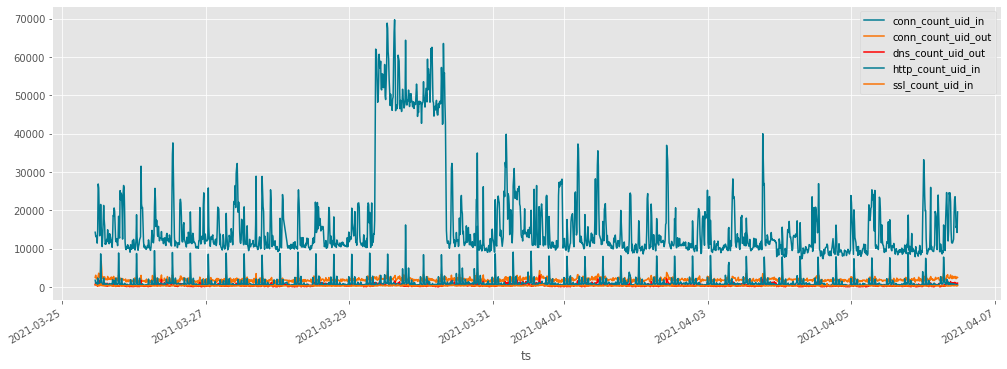

In [22]:
if not (test_rolling or test_decompose or test_stl):
    df_result = df[cols_selected]
    
print(df_result.info())
plt.rcParams["figure.figsize"] = (17, 6)
df_result.plot(use_index=True)

# Train, validation and test data

In [23]:
create_valid_data = False
n = len(df.index)
m = 300

if create_valid_data:
    df_train = df_result[:n-2*m]
    df_valid = df_result[n-2*m: n-m]
    df_test  = df_result.tail(m)
    print(df_train.shape, df_valid.shape, df_test.shape)
    
    df_train.to_csv('data/data_train.tsv', float_format='%.0f', sep='\t', index = False, header=True)
    df_valid.to_csv('data/data_valid.tsv', float_format='%.0f', sep='\t', index = False, header=True)
    df_test.to_csv( 'data/data_test.tsv',  float_format='%.0f', sep='\t', index = False, header=True)
else:
    df_train = df_result[:n-m]
    df_test  = df_result.tail(m)
    print(df_train.shape, df_test.shape)

    df_train.to_csv('data/data_train.tsv', float_format='%.0f', sep='\t', index = False, header=True)
    df_test.to_csv( 'data/data_test.tsv',  float_format='%.0f', sep='\t', index = False, header=True)

df_test

(1426, 5) (300, 5)


,conn_count_uid_in,conn_count_uid_out,dns_count_uid_out,http_count_uid_in,ssl_count_uid_in
ts,,,,,
2021-04-04 09:40:00,9663.0,1764.0,115.0,659.0,332.0
2021-04-04 09:50:00,11038.0,1839.0,204.0,1019.0,293.0
2021-04-04 10:00:00,10980.0,1714.0,116.0,881.0,242.0
2021-04-04 10:10:00,10576.0,1777.0,580.0,647.0,236.0
2021-04-04 10:20:00,10573.0,1893.0,308.0,541.0,214.0
...,...,...,...,...,...
2021-04-06 10:50:00,20419.0,2578.0,1021.0,648.0,354.0
2021-04-06 11:00:00,15486.0,2153.0,661.0,632.0,274.0
2021-04-06 11:10:00,15892.0,2571.0,942.0,659.0,273.0


# Another covid test

In [24]:
testy = pd.Series([378, 66, 76, 69, 111, 97, 95, 58, 197, 289, 159, 318, 225, 301, 368, 440, 242, 451, 476, 335, 913, 747, 720, 401, 688, 877, 1191, 1454, 1889, 1524, 1036, 1448, 2042, 1690, 2301, 2174, 1580, 1324, 1302, 1439, 2967, 3351, 3144, 3323, 2458, 2694, 3468, 4525, 3840, 4828, 4839, 3171, 1767, 5472, 4584, 5150, 3698, 1450, 1584, 2060, 4742, 5161, 4694, 3910, 1488, 786, 2063, 4326, 4876, 3992, 4084, 2476, 971, 2041, 3371, 2933, 2751, 2236, 1649, 645, 1464, 2839, 2352, 1848, 3433, 1606, 274, 6418, 2336, 2135, 1832, 2639, 1180, 160, 851, 1545, 1500, 1262, 1511, 479, 47, 847, 1163, 787, 806, 1278, 301, 41, 661, 1257, 936, 1515, 1611, 931, 62, 784, 2063, 1708, 1801, 2216, 808, 50, 873, 2225, 2284, 2172, 2879, 960, 279, 1163, 2205, 2336, 1862, 2161, 410, 24, 3333, 2571, 2251, 2049, 2275, 767, 216, 1548, 2296, 1851, 2176, 2884, 585, 766, 1320, 2538, 2667, 2473, 3099, 1068, 564, 1454, 3131, 2741, 2738, 3235, 2013, 481, 1583, 3684, 3435, 3245, 3833, 1723, 929, 2103, 4090, 3636, 4360, 4453, 1951, 588, 2763, 2428, 3519, 4772, 5947, 2462, 922, 2891, 5309, 5021, 4266, 6191, 3080, 1425, 4323, 3235, 4027, 5542, 5750, 3443, 1952, 2664, 6231, 5213, 5540, 6483, 5655])
prirastky = pd.Series([1, 2, 2, 2, 0, 3, 11, 11, 12, 17, 11, 24, 8, 19, 14, 41, 7, 19, 12, 10, 43, 23, 22, 22, 27, 37, 26, 24, 21, 14, 49, 47, 101, 19, 14, 13, 14, 27, 66, 28, 114, 72, 40, 72, 12, 26, 45, 81, 35, 13, 6, 2, 3, 7, 5, 7, 4, 1, 5, 8, 8, 16, 10, 0, 2, 0, 8, 4, 8, 3, 13, 1, 1, 0, 1, 6, 1, 1, 5, 2, 2, 2, 5, 0, 1, 0, 1, 0, 3, 1, 0, 2, 0, 2, 1, 2, 8, 1, 3, 3, 4, 0, 9, 1, 14, 10, 1, 1, 1, 18, 23, 13, 14, 7, 1, 2, 20, 13, 20, 29, 15, 1, 2, 31, 53, 19, 23, 8, 1, 6, 19, 24, 14, 11, 3, 1, 41, 37, 31, 29, 23, 38, 2, 23, 41, 20, 27, 45, 7, 10, 14, 49, 63, 43, 43, 30, 3, 16, 75, 49, 62, 54, 47, 5, 15, 100, 80, 123, 91, 40, 68, 28, 84, 90, 102, 114, 34, 41, 72, 53, 121, 137, 226, 88, 22, 91, 161, 178, 186, 201, 79, 48, 188, 92, 161, 235, 290, 131, 79, 175, 338, 360, 419, 552, 478])

df_testy = testy.to_frame()
df_prirastky = prirastky.to_frame()
df2 = pd.concat([df_testy, df_prirastky], axis=1)
df2.columns = ['testy', 'prirastky']
# df2

<AxesSubplot:xlabel='testy', ylabel='prirastky'>

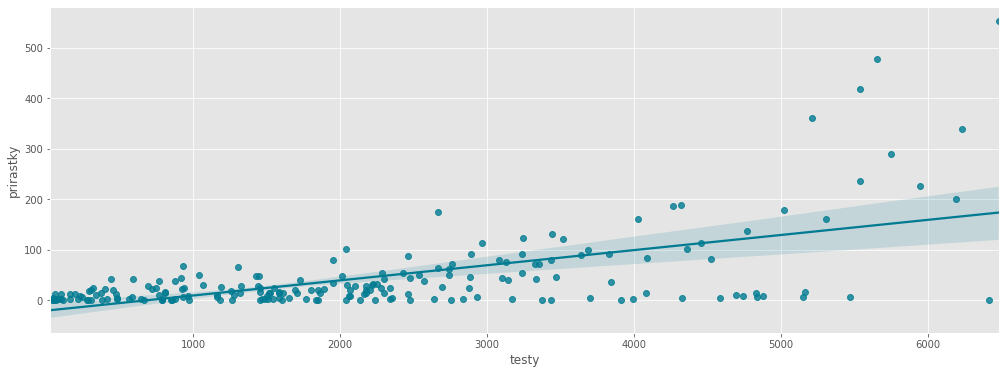

In [25]:
sns.regplot(data=df2, x='testy', y='prirastky')